<a href="INSERT_colab_python_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

label: exercise_2_a
# Exercise 2 (a)
Simulate a data set with $n = 100$ observations based on the relationship $y = \sin(x_1) + \varepsilon$ with noise term $\varepsilon$ following some distribution. Simulate $p=100$ additional covariates $x_2,\ldots,x_{101}$ that are not related to $y$.


label: install_packages
## Packages
If you want to reproduce the results, you'll need to install the following packages
```bash
!pip install numpy==1.26.4 matplotlib==3.8.4 scikit-learn==1.5.2 tensorflow==2.18.0
```

label: generating_data
## Generating the data

In [1]:
#| label: data_generation
import numpy as np 
import matplotlib.pyplot as plt

np.random.seed(509)     # for reproducibility
plt.style.use('ggplot') # to make plot look like in R

num_points = 100
num_additional_covs = 100

# the reader may find it interesting to play around with the noise amount
noise_amount = 0.1 

X = np.random.randn(num_additional_covs, num_additional_covs + 1)

y = np.sin(X[:, 0]) + np.random.randn(num_points) * noise_amount
print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (100, 101)
y shape: (100,)


### Visualizing the relationships
Let's see the relationships of $Y$ with $x_1$ and an unrelated covariate $x_2$

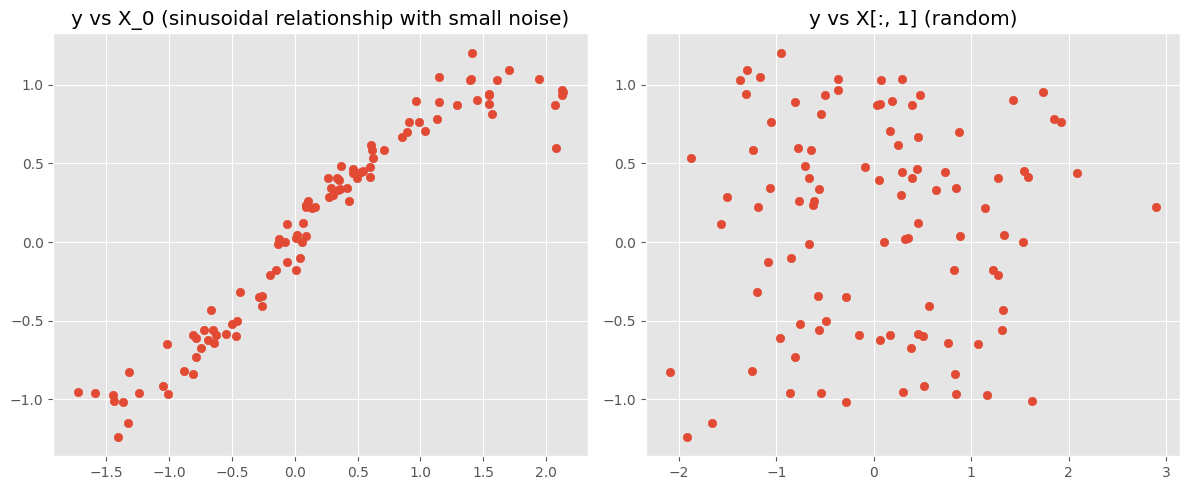

In [5]:
#| label: visualizing_relationships
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X[:, 0], y)
axs[0].set_title('y vs X_0 (sinusoidal relationship with small noise)')

axs[1].scatter(X[:, 1], y)
axs[1].set_title('y vs X[:, 1] (random)')

plt.tight_layout()
plt.show()

label: exercise_2_b
# Exercise 2 (b)
On this data set, use different models (and software packages) of your choice to demonstrate

* overfitting and underfitting;
* L1, L2 and elastic net regularization;
* the underdetermined problem;
* the bias-variance trade-off;
* early stopping using a simple neural network.

label: under_over_fitting_intro
## Underfitting and Overfitting
Let's try to approximate the (sinusoidal) relationship between $y$ and $x_1$ with:

1) a simple linear model 
2) a polynomial model of degree 7. 

Also, in order for us to see the effects of under/over-fitting not only visually but also numerically, lets split the data into training and test sets and calculate the training and test errors for each model.

label: imports_and_splitting
### Imports and Splitting the Data


In [24]:
#| label: imports_and_splitting
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error # other metrics can be used as well
from sklearn.model_selection import train_test_split

x_1 = X[:, 0].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(x_1, y, 
                                                    test_size=0.2, 
                                                    random_state=509)

label: underfitting_demo
### Underfitting demonstration

label: lin_reg_fit_and_eval
#### Fitting Linear Regression and Evaluating the Model

In [16]:
#| label: lin_reg_fit_and_eval
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)


print("Simple Linear Regression")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test  MSE: {test_mse:.4f}")
print(f"Test error is higher by {((test_mse - train_mse) / train_mse) * 100:.2f}%")

Simple Linear Regression
Train MSE: 0.0313
Test  MSE: 0.0595
Test error is higher by 90.07%


label: lin_reg_interpretation
#### Linear Regression Train/Test Error Interpretation

The training error was $~0.03$ and test error was $~0.06$ which may indicate that the model is overfitting, but we must first ask ourselves whether or not the results on the training set are actually good. If the training error is significantly higher than the Bayes risk (i.e. the minimum possible error), then we may be underfitting the data.

Visual inspection will help us here as well:

label: lin_reg_visual_inspection
#### Linear Regression Visual Inspection

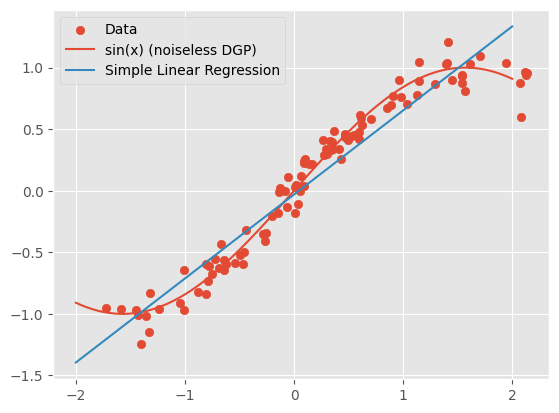

In [17]:
#| label: lin_reg_visual_inspection
plt.scatter(x_1, y, label='Data')

# noiseless DGP
x_vals = np.linspace(-2, 2, 100)
y_vals = np.sin(x_vals)
plt.plot(x_vals, y_vals, label='sin(x) (noiseless DGP)')

# simple linear regression
y_pred = lin_reg.predict(x_vals.reshape(-1, 1))
plt.plot(x_vals, y_pred,
         label='Simple Linear Regression')
plt.legend()

label: lin_reg_plot_interpretation
#### Linear Regression Plot Interpretation
By plotting the predictions against the actual data and the $\sin x$ function (noiseless DGP) we can see that the model lacks complexity $\Rightarrow$ suffers from underfitting problem.

label: overfitting_demo
### Overfitting demonstration

label: poly_reg_fit_and_eval
#### Fitting Polynomial Regression and Evaluating the Model

In [26]:
#| label: poly_reg_fit_and_eval
poly_degree = 50
poly = PolynomialFeatures(degree=poly_degree)
poly.fit(X_train) 

# Creating our design matrix for the polynomial regression
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# don't get confused by the model name, we are fitting it on the transformed data
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_train_pred = poly_reg.predict(X_train_poly)
y_test_pred = poly_reg.predict(X_test_poly)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Polynomial Regression (degree=50)")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test  MSE: {test_mse:.4f}")
print(f"Test error is higher by {((test_mse - train_mse) / train_mse) * 100:.2f}%")

Polynomial Regression (degree=50)
Train MSE: 0.1385
Test  MSE: 145219784.4922
Test error is higher by 104827038582.99%


label: poly_reg_interpretation
#### Polynomial Regression Train/Test Error Interpretation

Test error is undescribably higher than the training error, this is a clear sign of overfitting. The model is too complex for the data and it has learned the noise in the training set.

Let's see this visually:

label: poly_reg_visual_inspection
#### Polynomial Regression Visual Inspection

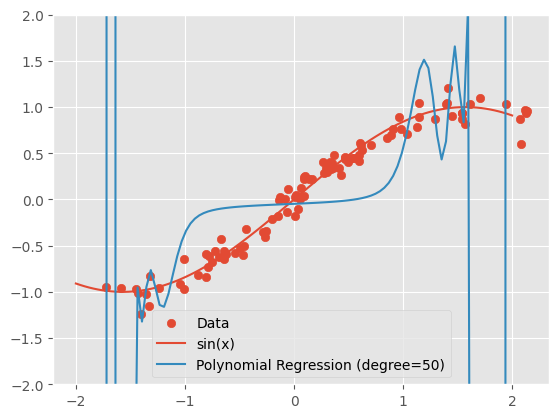

In [27]:
#| label: poly_reg_visual_inspection
plt.scatter(x_1, y, label='Data')

# noiseless DGP
x_vals = np.linspace(-2, 2, 100)
y_vals = np.sin(x_vals)
plt.plot(x_vals, y_vals, label='sin(x)')

# inference
y_vals_transformed = poly.transform(x_vals.reshape(-1, 1))
y_pred = poly_reg.predict(y_vals_transformed)

# plotting polynomial regression predictions
plt.plot(x_vals, y_pred,
         label=f'Polynomial Regression (degree={poly_degree})')

# setting limits to make the plot readable (the model sometimes predicts extreme values)
plt.ylim(-2, 2)


plt.legend()

label: poly_reg_plot_interpretation
#### Polynomial Regression Plot Interpretation
By looking at the predictions for the points around -1.3 we can nicely see how much the model bends to pass through the training data points, and learns the noise instead of the actual pattern.

The reader may find it interesting to decrease the degree of the polynomial to make the demonstration less extreme, and for degree = 7 you may even notice that the train/test errors alone indicate less overfitting than in the case of simple linear regression.

Also, we encourage the reader to try to find the optimal degree of the polynomial.

label: regularization_demo
## L1, L2 and Elastic Net Regularization

Now let's demonstrate different types of regularization techniques and observe how they affect the coefficient paths (for each hyperparameter lambda the resulting model's coefficients).

label: regularization_helper_function
### Helper Function for Plotting Regularization Paths

Here `sklearn`'s `enet_path` function is used which under the hood fits a `ElasticNet` model. This makes the code much shorter since by passing 1, 0 or something in between as the `l1_ratio` parameter we can get the Lasso, Ridge or Elastic Net regularization paths respectively.

In [7]:
#| label: regularization_helper_function
from sklearn.linear_model import enet_path

def plot_regularization_paths(X, y, l1_ratio, title):
    alphas, coefs, _ = enet_path(X, y, l1_ratio=l1_ratio)

    plt.figure()
    for coef in coefs:
        plt.plot(alphas, coef)
    
    plt.xscale("log")
    plt.xlabel("lambda")
    plt.ylabel("Coefficients")
    plt.title(title)
    plt.show()

label: l1_lasso_regularization
## L1 (Lasso) Regularization

For small lambda values (weak penalization) we can see that the uninformative covariates do have non-zero coefficients, but by increasing the lambda they eventually go to **exactly** zero. However, when we penalize the coefficients too strongly, the coefficient of $x_1$ also goes to zero, which is bad, since $x_1$ is actually informative.

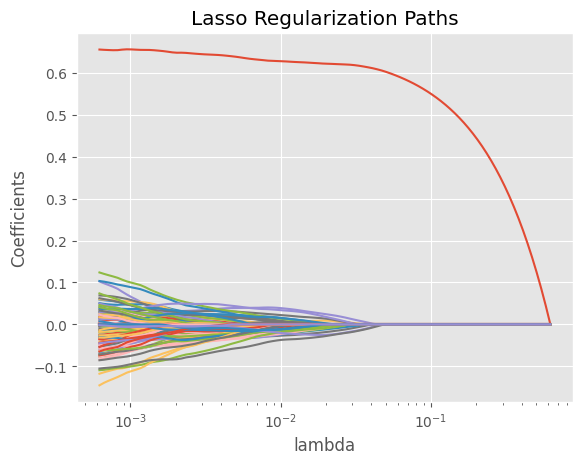

In [8]:
#| label: l1_lasso_plot 
plot_regularization_paths(X, y, l1_ratio=1, title="Lasso Regularization Paths")

label: l2_ridge_regularization
## L2 (Ridge) Regularization

A few differences from the Lasso plot above:

- The lambda values are much bigger here (smallest being around $10^4$ instead of $10^{-3}$)
- As a result we also see that the coefficients are much smaller (0.0001 instead of 0.65)
- Also, most importantly the coefficients **do not go to zero**, but rather to very small values. The Lasso performs feature selection, while the Ridge does not. 

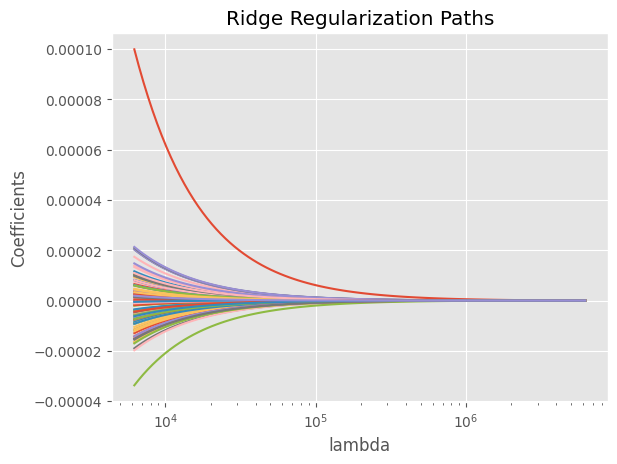

In [5]:
#| label: l2_ridge_plot
plot_regularization_paths(X, y, l1_ratio=1e-7, title="Ridge Regularization Paths")

label: elastic_net_regularization
## Elastic Net Regularization (with l1_ratio = 0.3)

This approach is somewhere in-between the two above - lambda values are bigger than Lasso, but not as big as Ridge.

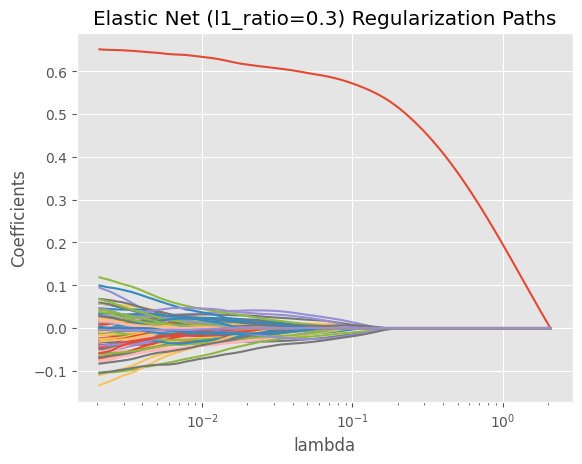

In [9]:
#| label: elastic_net_plot
plot_regularization_paths(X, y, l1_ratio=0.3, title="Elastic Net (l1_ratio=0.3) Regularization Paths")

label: regularization_comparison_note
### Comparing Regularization Methods

The reader may find it interesting to compare the plots for the same lambda values across different regularization techniques.

label: underdetermined_problem
## The Underdetermined Problem

As a reminder, we can obtain an analytic solution for a linear regression model with Mean Squared Error (MSE) loss by solving the normal equations 
$$
\beta = (X^TX)^{-1}X^TY
$$

The **underdetermined problem** arises when we have more covariates than observations, because in that case then the design matrix ($X$) is not full rank $\Rightarrow$ the inverse of the $X^T X$ does not exist $\Rightarrow$ we cannot solve the normal equations.

In [15]:
#| label: check_x_shape_determinant
print(f"X shape: {X.shape}")

# We have more covariates than samples, but practically this does not imply 
# that we have a zero determinant 
print(f"Determinant of X^T X: {np.linalg.det(X.T @ X)}")

X shape: (100, 101)
Determinant of X^T X: 6.1344097025398345e+143


In [17]:
#| label: underdetermined_fewer_samples
# Let's select even fewer samples to demonstrate the underdetermined problem
X_head = X[:10]
y_head = y[:10]

print(f"Determinant of X_head^T X_head: {np.linalg.det(X_head.T @ X_head)}")

Determinant of X_head^T X_head: 0.0


label: calc_xt_x_determinant
Although we see that the determinant is zero, let's try to compute the inverse (although in practice we would obtain the analytic solution (for the normal equation) by solving the System of Linear Equations $X^TX\beta = X^TY$, and avoiding the inverse altogether).

In [18]:
np.linalg.inv(X_head.T @ X_head)

array([[ 3.80685649e+15, -4.50966877e+14,  7.86888959e+14, ...,
         6.86997422e+14,  8.79488403e+14, -3.58040252e+15],
       [-1.80492861e+15,  1.44481770e+14, -4.80891098e+14, ...,
        -2.97567284e+14, -5.30711014e+14,  1.97063574e+15],
       [ 4.49351255e+15, -1.05427086e+15,  7.45124500e+14, ...,
         5.97798990e+14,  7.78034754e+14, -3.31237421e+15],
       ...,
       [ 1.52674452e+15, -2.10357661e+14,  3.65081812e+14, ...,
         2.75064676e+14,  4.25054295e+14, -1.28890762e+15],
       [-1.26605186e+15,  3.06985899e+14, -2.46112775e+14, ...,
        -1.66443082e+14, -1.27153678e+14,  6.48198239e+14],
       [ 3.26716843e+15, -8.41416791e+14,  9.14888657e+14, ...,
         3.69982601e+14,  9.73971694e+14, -3.15364389e+15]])

label: inverse_existence_explanation
The code above does produce an output (although it is mathematically impossible), since from the machine's perspective the matrix is not singular, because of the floating point approximations. The reader may dug deeper into the topic by following [this](https://stackoverflow.com/questions/28712734/numpy-possible-for-zero-determinant-matrix-to-be-inverted) Stack Overflow post.

We'll demonstrate the underdetermined problem with a manually created example.
 

In [22]:
#| label: singular_matrix_example
X_singular = np.array([
    [1, 1],  
    [1, 1],   
], dtype=float)

# y can be anything
y_any = np.array([1, 2])

print("X shape:", X_singular.shape)
print("y shape:", y_any.shape)
print(f"Rank(X): ({np.linalg.matrix_rank(X_singular)}) < Full-rank ({X_singular.shape[1]})")

try:
    coefs = np.linalg.solve(X_singular.T @ X_singular, X_singular.T @ y_any)
    print("Direct solution via solve(X^T X, X^T y):", coefs)
except np.linalg.LinAlgError as e:
    print("Error from np.linalg.solve:", e)

X shape: (2, 2)
y shape: (2,)
Rank(X): (1) < Full-rank (2)
Error from np.linalg.solve: Singular matrix


label: bias_variance_tradeoff
## The Bias-Variance Trade-off

Let's demonstrate the bias-variance trade-off by comparing polynomial models of different degrees.

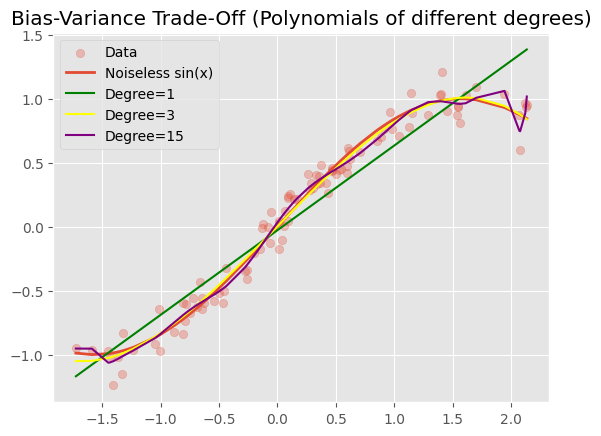

In [25]:
#| label: bias_variance_visualization
x_1 = X[:, 0]
sorted_x_1 = np.sort(x_1)

degrees = [1, 3, 15]

plt.figure()
plt.scatter(x_1, y, alpha=0.3, label='Data')
plt.plot(sorted_x_1, np.sin(sorted_x_1), label='Noiseless sin(x)', linewidth=2)

colors = ['green', 'yellow', 'purple', 'blue', 'brown']
for deg, col in zip(degrees, colors):
    poly_tmp = PolynomialFeatures(degree=deg)
    X_poly_tmp = poly_tmp.fit_transform(X[:, [0]])
    
    model_tmp = LinearRegression().fit(X_poly_tmp, y)
    sorted_x1_poly_tmp = poly_tmp.transform(sorted_x_1.reshape(-1, 1))
    
    Y_poly_tmp = model_tmp.predict(sorted_x1_poly_tmp)
    plt.plot(sorted_x_1, Y_poly_tmp, label=f"Degree={deg}", linestyle='-', c=col)

plt.legend()
plt.title("Bias-Variance Trade-Off (Polynomials of different degrees)")
plt.show()

label: bias_variance_interpretation
### Interpreting the Bias-Variance Trade-off

We can see that the green line (degree=1) is too simple and will have a underfitting (high bias) problem. On the other hand, the purple line (degree=15) is too complex and will have a overfitting (high variance) problem. The yellow line (degree=3) serves as a good compromise between the two.

We invite the reader to experiment with different degrees of the polynomial, maybe additionally looking at train/test errors and tring to find the optimal degree.

label: early_stopping_neural_network
## Early Stopping using a Simple Neural Network

First of all let's see how the model performs without early stopping.

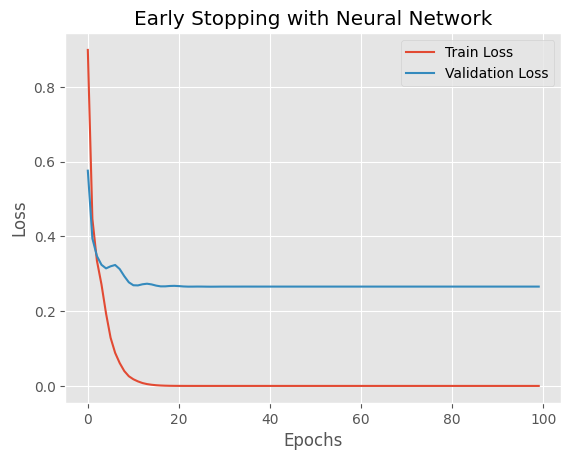

In [ ]:
#| label: neural_network_early_stopping
# TensorFlow is used for simplicity, in practice we may often prefer PyTorch
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

tf.random.set_seed(509)

# Simple MLP model
neural_network = Sequential()
neural_network.add(Dense(units=50, activation='relu', input_shape=(X.shape[1],)))
neural_network.add(Dense(units=50, activation='relu'))
neural_network.add(Dense(units=1, activation='linear'))

neural_network.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

history = neural_network.fit(
    X, 
    y, 
    batch_size=16, 
    epochs=100,
    validation_split=0.2, 
    verbose=0  # Set to 1 if you want to see training logs
)

# Plot the training history
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Early Stopping with Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

label: no_early_stopping_interpretation
### Interpreting Results Without Early Stopping

We can see that starting from epoch 15 model did not make any significant improvements. That's not the case here, but usually the model also starts to overfit to the training data, and the validation loss rises when we let it run for too many epochs. 

In order to avoid overfitting and use our computational resources more efficiently, we can use early stopping. We will track the validation loss and if for a given `patience` period (e. g. 5 epochs) the validation loss (`monitor`) does not improve by a given threshold (`min_delta`) (e. g. 0.01), we stop the training.

*Side note:*

In our case the validation loss did not start rising because the model had already achieved perfect fit (loss = 0) to the training data, so the weights were not updating anymore, and the validation loss did not change. Usually, for more complex DGP's achieving perfect fit is not possible.

c:\Users\hayk_\OneDrive\Desktop\03_lecture_sl\sl\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


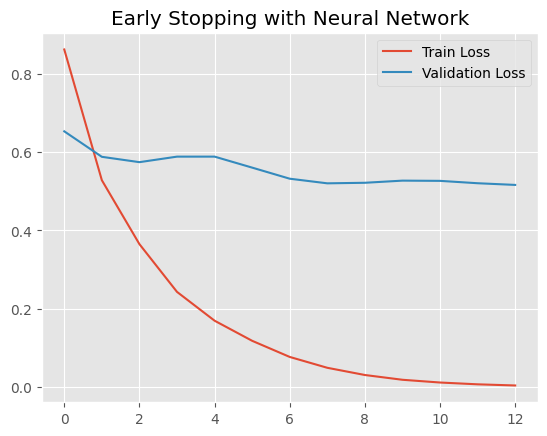

In [8]:
#| label: early_stopping
# TensorFlow is used for simplicity, in practice we may often prefer PyTorch
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(509)

neural_network = Sequential()
neural_network.add(Dense(units=50, activation='relu', input_shape=(X.shape[1],)))
neural_network.add(Dense(units=50, activation='relu'))
neural_network.add(Dense(units=1, activation='linear'))

neural_network.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)


# Early stopping callback
early_stop = EarlyStopping(patience=5,
                           monitor="val_loss", # this is the defauly
                           min_delta=0.01,  # Minimum change to qualify as an improvement 
                           restore_best_weights=True)

history = neural_network.fit(
    X, 
    y, 
    batch_size=16, 
    epochs=100,
    validation_split=0.2, 
    callbacks=[early_stop], # Early stopping 
    verbose=0  
)

# Plot the training history
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Early Stopping with Neural Network")
plt.show()

label: early_stopping_interpretation
### Interpreting Early Stopping Results

We see that the neural network ran only for approximately 12 epochs, although we specified 100 epochs. This is because we used early stopping and the optimizer stopped after 5 epochs without significant improvement in the validation loss.

We encourage the reader to split the data and look into train/test errors for the same neural network with and without early stopping. What do you observe regarding overfitting?